In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import wandb
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from geomloss import SamplesLoss 
from utilities import *
from model import model_MAF as model_MAF

import FrEIA
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom


from train_khi_AE_refactored.encoder_decoder import Encoder
from train_khi_AE_refactored.encoder_decoder import Conv3DDecoder, MLPDecoder
from train_khi_AE_refactored.loss_functions import EarthMoversLoss
from train_khi_AE_refactored.networks import ConvAutoencoder, VAE
        


Exception No module named 'ChamferDistancePytorch.chamfer6D' found While loading loss function.


In [2]:
def smooth_data(data, window_size=5):
    """Smooth data using a moving average."""
    return uniform_filter1d(data, size=window_size, mode='nearest')

def plot_radiation(ground_truth_intensity, predicted_intensity=None, frequency_range=512, t=1000, gpu_box=0, path='',
                   enable_wandb=False):
    """
    Plot radiation intensity against frequency and compute MSE and relative MSE
    between ground truth and prediction. Compatible with both NumPy arrays and PyTorch tensors.

    Parameters:
    - ground_truth_intensity: A tensor or array of ground truth radiation spectra values.
    - predicted_intensity: A tensor or array of predicted radiation spectra values (optional).
    - t: Time step for the title (default=1000).
    - gpu_box: Identifier for the GPU box (default=0).
    - path: Path to save the plot (optional).
    - enable_wandb: Enable logging to Weights & Biases (default=False).
    """
    
    import numpy as np
    import matplotlib.pyplot as plt

    def to_numpy(data):
        """Convert PyTorch tensor to NumPy array if necessary."""
        if 'torch' in str(type(data)):
            return data.cpu().numpy()
        return data

    # Load frequency data
    frequency = np.load("/bigdata/hplsim/aipp/Jeyhun/khi/part_rad/omega.npy")[:frequency_range]
    
    # Ensure ground_truth_intensity and predicted_intensity are NumPy arrays
    ground_truth_intensity = to_numpy(ground_truth_intensity)[:frequency_range]
    ground_truth_smoothed = smooth_data(ground_truth_intensity)
    
    plt.figure(figsize=(10, 6))
    plt.plot(frequency, ground_truth_intensity, label='GT Radiation Intensity (Raw)', color='blue', linewidth=2)
    
    mse, rel_mse = 0, 0  # Initialize MSE and Relative MSE
    
    if predicted_intensity is not None:
        predicted_intensity = to_numpy(predicted_intensity)[:frequency_range]
        predicted_smoothed = smooth_data(predicted_intensity)
        
        plt.plot(frequency, predicted_smoothed, label='Predicted Radiation Intensity (Smoothed)', linestyle='--', color='red', marker='o', markersize=5, zorder=1)
        plt.plot(frequency, predicted_intensity, label='Predicted Radiation Intensity (Raw)', linestyle='--', color='red', alpha=0.3, zorder=0, markersize=3)
        plt.xscale("log")
        
        # Compute MSE
        mse = np.mean((ground_truth_intensity - predicted_intensity) ** 2)
        
        # Compute Relative MSE
        rel_mse = mse / np.mean(ground_truth_intensity ** 2)
    
    # Update plot title with MSE and Relative MSE if prediction is provided
    if predicted_intensity is not None:
        plt.title(f'Radiation Intensity vs. Frequency t = {t}, box = {gpu_box}\nMSE = {mse:.2e}, Relative MSE = {rel_mse:.2e}')
    else:
        plt.title(f'Radiation Intensity vs. Frequency t = {t}, box = {gpu_box}')
    
    plt.xlabel('Frequency')
    plt.ylabel('Intensity (log scale)')
    plt.legend()
    plt.grid(True)
    
    if path:
        plt.savefig(f'{path}/radiation_plots_{t}_{gpu_box}.png')
    
    if enable_wandb:
        import wandb
        wandb.log({"Radiation (t={},box={})".format(t, gpu_box): wandb.Image(plt)})
        plt.close()
    else:
        plt.show()

In [3]:
def filter_dims(phase_space, property_="positions"):
    
    if property_ == "positions":
        return phase_space[:,:,:3]
    elif property_ == "momentum":
        return phase_space[:,:,3:6]
    elif property_ == "force":
        return phase_space[:,:,6:]
    elif property_ == "momentum_force":
        return phase_space[:,:,3:]
    else:
        return phase_space

In [4]:
def create_momentum_density_plots(px, py, pz,
                                  px_pr, py_pr, pz_pr,
                                  px_pr_ae, py_pr_ae, pz_pr_ae,
                                  chamfers_loss=None,emd_loss=None,
                                  bins=100, t=1000, gpu_box =0, path='',
                                  enable_wandb = False):
    
    # Specify the number of bins for each axis
    bins_px = np.linspace(min(px), max(px), bins)
    bins_py = np.linspace(min(py), max(py), bins)
    bins_pz = np.linspace(min(pz), max(pz), bins)
    
    loss_info = ''
    if chamfers_loss is not None:
        loss_info += '\nChamfers: {:.4f}'.format(chamfers_loss)
    if emd_loss is not None:
        loss_info += '\nEMD: {:.4f}'.format(emd_loss)
    
    # Create subplots for each plane
    plt.figure(figsize=(15, 15)) 
    
    # px-py Plane Ground Truth
    plt.subplot(331)
    plt.hist2d(px, py, bins=[bins_px, bins_py], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('px')
    plt.ylabel('py')
    plt.title('px-py GT at t = {}, box = {}'.format(t,gpu_box))
    
    # px-pz Plane Ground Truth
    plt.subplot(332)
    plt.hist2d(px, pz, bins=[bins_px, bins_pz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('px')
    plt.ylabel('pz')
    plt.title('px-pz GT at t = {}, box = {}'.format(t,gpu_box))
    
    # py-pz Plane Ground Truth
    plt.subplot(333)
    plt.hist2d(py, pz, bins=[bins_py, bins_pz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('py')
    plt.ylabel('pz')
    plt.title('py-pz GT at t = {}, box = {}'.format(t,gpu_box))
    
    # px-py Plane Prediction
    plt.subplot(334)
    plt.hist2d(px_pr, py_pr, bins=[bins_px, bins_py], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('px_pr')
    plt.ylabel('py_pr')
    plt.title('px-py INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # px-pz Plane Prediction
    plt.subplot(335)
    plt.hist2d(px_pr, pz_pr, bins=[bins_px, bins_pz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('px_pr')
    plt.ylabel('pz_pr')
    plt.title('px-pz INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # py-pz Plane Prediction
    plt.subplot(336)
    plt.hist2d(py_pr, pz_pr, bins=[bins_py, bins_pz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('py_pr')
    plt.ylabel('pz_pr')
    plt.title('py-pz INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # px-py Plane Prediction
    plt.subplot(337)
    plt.hist2d(px_pr_ae, py_pr_ae, bins=[bins_px, bins_py], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('px_pr')
    plt.ylabel('py_pr')
    plt.title('px-py AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # px-pz Plane Prediction
    plt.subplot(338)
    plt.hist2d(px_pr_ae, pz_pr_ae, bins=[bins_px, bins_pz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('px_pr')
    plt.ylabel('pz_pr')
    plt.title('px-pz AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # py-pz Plane Prediction
    plt.subplot(339)
    plt.hist2d(py_pr_ae, pz_pr_ae, bins=[bins_py, bins_pz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('py_pr')
    plt.ylabel('pz_pr')
    plt.title('py-pz AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    plt.tight_layout()
    
    # Save the plots as image files
    if path:
        plt.savefig(path + '/momentum_density_plots_{}_{}.png'.format(t,gpu_box))
    
    if enable_wandb == True:
        # Log the overlapping histogram plot
        wandb.log({"Px vs Py vs Pz histograms (t={},box={})".format(t,gpu_box): wandb.Image(plt)})

        plt.close()
    else:
        plt.show()   


def create_force_density_plots(fx, fy, fz,
                               fx_pr, fy_pr, fz_pr,
                               fx_pr_ae, fy_pr_ae, fz_pr_ae,
                               chamfers_loss=None,emd_loss=None,
                               bins=100, t=1000, gpu_box =0, path='',
                               enable_wandb = False):
    
    # Specify the number of bins for each axis
    bins_fx = np.linspace(min(fx), max(fx), bins)
    bins_fy = np.linspace(min(fy), max(fy), bins)
    bins_fz = np.linspace(min(fz), max(fz), bins)
    
    loss_info = ''
    if chamfers_loss is not None:
        loss_info += '\nChamfers: {:.4f}'.format(chamfers_loss)
    if emd_loss is not None:
        loss_info += '\nEMD: {:.4f}'.format(emd_loss)
        
    # Create subplots for each plane
    plt.figure(figsize=(15, 15))  # Adjust the figure size
    
    # fx-fy Plane Ground Truth
    plt.subplot(331)
    plt.hist2d(fx, fy, bins=[bins_fx, bins_fy], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('fx')
    plt.ylabel('fy')
    plt.title('fx-fy GT at t = {}, box = {}'.format(t,gpu_box))
    
    # fx-fz Plane Ground Truth
    plt.subplot(332)
    plt.hist2d(fx, fz, bins=[bins_fx, bins_fz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('fx')
    plt.ylabel('fz')
    plt.title('fx-fz GT at t = {}, box = {}'.format(t,gpu_box))
    
    # fy-fz Plane Ground Truth
    plt.subplot(333)
    plt.hist2d(fy, fz, bins=[bins_fy, bins_fz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('fy')
    plt.ylabel('fz')
    plt.title('fy-fz GT at t = {}, box = {}'.format(t,gpu_box))
    
    # fx-fy Plane Prediction
    plt.subplot(334)
    plt.hist2d(fx_pr, fy_pr, bins=[bins_fx, bins_fy], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('fx_pr')
    plt.ylabel('fy_pr')
    plt.title('fx-fy INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fx-fz Plane Prediction
    plt.subplot(335)
    plt.hist2d(fx_pr, fz_pr, bins=[bins_fx, bins_fz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('fx_pr')
    plt.ylabel('fz_pr')
    plt.title('fx-fz INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fy-fz Plane Prediction
    plt.subplot(336)
    plt.hist2d(fy_pr, fz_pr, bins=[bins_fy, bins_fz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('fy_pr')
    plt.ylabel('fz_pr')
    plt.title('fy-fz INN Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fx-fy Plane Prediction
    plt.subplot(337)
    plt.hist2d(fx_pr_ae, fy_pr_ae, bins=[bins_fx, bins_fy], cmap='Blues')
    plt.colorbar(label='Density')
    plt.xlabel('fx_pr')
    plt.ylabel('fy_pr')
    plt.title('fx-fy AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fx-fz Plane Prediction
    plt.subplot(338)
    plt.hist2d(fx_pr_ae, fz_pr_ae, bins=[bins_fx, bins_fz], cmap='Greens')
    plt.colorbar(label='Density')
    plt.xlabel('fx_pr')
    plt.ylabel('fz_pr')
    plt.title('fx-fz AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    # fy-fz Plane Prediction
    plt.subplot(339)
    plt.hist2d(fy_pr_ae, fz_pr_ae, bins=[bins_fy, bins_fz], cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('fy_pr')
    plt.ylabel('fz_pr')
    plt.title('fy-fz AE Pred at t = {}, box = {}{}'.format(t,gpu_box, loss_info))
    
    plt.tight_layout()
    
    # Save the plots as image files
    if path:
        plt.savefig(path + '/force_density_plots_{}_{}.png'.format(t,gpu_box))
    
    if enable_wandb == True:
        # Log the overlapping histogram plot
        wandb.log({"Fx vs Fy vs FZ histograms (t={},box={})".format(t,gpu_box): wandb.Image(plt)})

        plt.close()
    else:
        plt.show()         

In [5]:
def normalize_mean_6d(original_array, mean_std_file):
    data_stats = np.load(mean_std_file)
    # Extract global mean and standard deviation
    global_mean_momentum = data_stats['mean_momentum']
    global_mean_force = data_stats['mean_force']
    global_std_momentum = data_stats['std_momentum']
    global_std_force = data_stats['std_force']

    # Normalize x, y, z positions
    xyz_columns = original_array[:, :3]
    mins = xyz_columns.min(axis=0)
    maxs = xyz_columns.max(axis=0)
    xyz_columns_normalized = (xyz_columns - mins) / (maxs - mins)

    # Mean normalization for momentum dimensions 
    momentum_columns_normalized = (original_array[:, 3:6] - global_mean_momentum) / global_std_momentum

    # Mean normalization for force dimensions
    force_columns_normalized = (original_array[:, 6:9] - global_mean_force) / global_std_force

    # Combine the normalized columns into one array
    normalized_array = np.concatenate((xyz_columns_normalized, momentum_columns_normalized, force_columns_normalized), axis=1)
    return normalized_array

In [6]:
def particle_transformation(p_gt, gpu_index,normalise=True):
    
    if normalise==True:
        p_gt = [normalize_mean_6d(element,mean_std_file_path.format(config["t0"],config["t1"])) for element in p_gt]

    p_gt = [random_sample(element, sample_size=config["particles_to_sample"]) for element in p_gt]
    # p_gt = np.array(p_gt, dtype = np.float32)
    p_gt = torch.from_numpy(np.array(p_gt, dtype = np.float32))

    p_gt = filter_dims(p_gt, property_=config["property_"])
    p_gt = p_gt[gpu_index]
    
    return p_gt

In [7]:
def generate_plots(model, t_index,gpu_index,pathpattern1,pathpattern2, config, device, enable_wandb = False):
    
    p_gt_all = np.load(pathpattern1.format(t_index),allow_pickle = True)
    
    p_gt = particle_transformation(p_gt_all, gpu_index,normalise=True)
    
    p_gt_og = particle_transformation(p_gt_all, gpu_index,normalise=False)
    

    # Load radiation data
    r = torch.from_numpy(np.load(pathpattern2.format(t_index)).astype(np.cfloat))

    # ampliudes in each direction
    amp_x = torch.abs(r[:, 0, :]).to(torch.float32)
    amp_y = torch.abs(r[:, 1, :]).to(torch.float32)
    amp_z = torch.abs(r[:, 2, :]).to(torch.float32)

    #spectra
    r = amp_x**2 + amp_y**2 + amp_z**2

    r = r[gpu_index]
    
    #log transformation
    r = torch.log(r+config["rad_eps"])
    
    cond = r.reshape(1,-1).to(device)

    p_gt_clone = p_gt.clone()
    p_gt_clone = p_gt_clone.unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        pc_pr, lat_z_pred = model.reconstruct_inn(p_gt_clone, cond)
        _,_,_, pc_pr_ae, z_encoded = model.base_network(p_gt_clone)
        with torch.no_grad():
            output = model.inner_model(z_encoded)

        rad_pred = output[:, config["ndim_z"]:].squeeze()
        
        #denormalise radiation
        # rad_pred = torch.exp(rad_pred) - config["rad_eps"]
        plot_radiation(ground_truth_intensity = r, predicted_intensity = rad_pred, t = t_index, gpu_box = gpu_index, enable_wandb = enable_wandb)
        # plot_radiation(ground_truth_intensity = r_clone, predicted_intensity = rad_pred, t = t_index, gpu_box = gpu_index, enable_wandb = enable_wandb)

    
    p_gt= p_gt_og
    p_gt= p_gt.cpu().numpy()
    pc_pr= pc_pr.squeeze().cpu().numpy()
    pc_pr_ae= pc_pr_ae.squeeze().cpu().numpy()
    
    
    pc_pr = denormalize_mean_6d(pc_pr, mean_std_file = mean_std_file_path.format(config["t0"],config["t1"]))
    pc_pr_ae = denormalize_mean_6d(pc_pr_ae, mean_std_file = mean_std_file_path.format(config["t0"],config["t1"]))

    # Visualization code for momentum
    px = p_gt[:, 0]  # Px component of momentum
    py = p_gt[:, 1]  # Py component of momentum
    pz = p_gt[:, 2]  # Pz component of momentum

    px_pr = pc_pr[:, 0]  # Px component of momentum
    py_pr = pc_pr[:, 1]  # Py component of momentum
    pz_pr = pc_pr[:, 2]  # Pz component of momentum
    
    px_pr_ae = pc_pr_ae[:, 0]  # Px component of momentum
    py_pr_ae = pc_pr_ae[:, 1]  # Py component of momentum
    pz_pr_ae = pc_pr_ae[:, 2]  # Pz component of momentum

    # Visualization code for force
    fx = p_gt[:, 3]  # Fx component of force
    fy = p_gt[:, 4]  # Fy component of force
    fz = p_gt[:, 5]  # Fz component of force

    fx_pr = pc_pr[:, 3]  # Fx component of force
    fy_pr = pc_pr[:, 4]  # Fy component of force
    fz_pr = pc_pr[:, 5]  # Fz component of force
    
    fx_pr_ae = pc_pr_ae[:, 3]  # Fx component of force
    fy_pr_ae = pc_pr_ae[:, 4]  # Fy component of force
    fz_pr_ae = pc_pr_ae[:, 5]  # Fz component of force

    create_momentum_density_plots(px, py, pz,
                          px_pr, py_pr, pz_pr,
                          px_pr_ae, py_pr_ae, pz_pr_ae,     
                          bins=100, t=t_index, gpu_box=gpu_index,
                          #chamfers_loss = cd.item(),
                          #emd_loss=emd.item(),
                          enable_wandb = enable_wandb
                         ) 

    create_force_density_plots(fx, fy, fz,
                       fx_pr, fy_pr, fz_pr,
                       fx_pr_ae, fy_pr_ae, fz_pr_ae,     
                       bins=100, t=t_index, gpu_box=gpu_index,
                       #chamfers_loss = cd.item(),
                       #emd_loss=emd.item(),
                       enable_wandb = enable_wandb
                      )

    return r, rad_pred, p_gt, pc_pr, pc_pr_ae


def validate_model(model, valid_data_loader, property_, device):
    model.eval()
    val_loss_avg = []
    
    with torch.no_grad():
        for idx in range(len(valid_data_loader)):
            timestep_index, validation_boxes, p, r = valid_data_loader[idx]
            p = filter_dims(p, property_)
            p = p.to(device)
            r = r.to(device)
            val_loss,_,_,_,_,_ = model(x=p,y=r)
            val_loss_avg.append(val_loss.mean().item())
    val_loss_overall_avg = sum(val_loss_avg) / len(val_loss_avg)
    return val_loss_overall_avg
        

    
    
class INNModel(nn.Module):
    def __init__(self,
                 ndim_tot,
                 ndim_x,
                 ndim_y,
                 ndim_z,
                 loss_fit,
                 loss_latent,
                 loss_backward,
                 lambd_predict=1.0,
                 lambd_latent=1.0,
                 lambd_rev=1.0,
                 zeros_noise_scale=5e-5,
                 y_noise_scale=1e-2,
                 hidden_size = 4,
                 num_coupling_layers=0,
                 activation= 'relu',
                 device='cpu'):
        super(INNModel, self).__init__()
        
        self.device = torch.device(device) 
        self.ndim_tot = ndim_tot
        self.ndim_x = ndim_x
        self.ndim_y = ndim_y
        self.ndim_z = ndim_z
        self.loss_fit = loss_fit
        self.loss_latent = loss_latent
        self.loss_backward = loss_backward
        self.lambd_predict = lambd_predict
        self.lambd_latent = lambd_latent
        self.lambd_rev = lambd_rev
        self.zeros_noise_scale = zeros_noise_scale
        self.y_noise_scale = y_noise_scale
        self.hidden_size = hidden_size
        
        
        # Activation functions
        activation_functions = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'elu': nn.ELU(),
            'silu': nn.SiLU(),
            'leaky_relu': nn.LeakyReLU(),
            'gelu': nn.GELU()
        }
        self.activation = activation_functions.get(activation)
        
        # Define the subnet_constructor using a method
        subnet_constructor = lambda c_in, c_out: self.subnet_fc(c_in, c_out)
            
        self.model = self._build_model(subnet_constructor, 
                                           num_coupling_layers)

    def subnet_fc(self, c_in, c_out):
        # Define the fully connected subnet
        return nn.Sequential(nn.Linear(c_in, self.hidden_size), self.activation,
                             nn.Linear(self.hidden_size, c_out))

    def _build_model(self, subnet_constructor, num_coupling_layers):
        nodes = [InputNode(self.ndim_tot, name='input')]

        for k in range(num_coupling_layers):
            nodes.append(Node(nodes[-1],
                              GLOWCouplingBlock,
                              {'subnet_constructor': subnet_constructor, 'clamp':2.0},
                              name=f'coupling_{k}'))
            nodes.append(Node(nodes[-1],
                              PermuteRandom,
                              {'seed':k},
                              name=f'permute_{k}'))

        nodes.append(OutputNode(nodes[-1], name='output'))

        return ReversibleGraphNet(nodes, verbose=False)

    def compute_losses(self, x, y):
        device = self.device 
        x = x.to(device)
        y = y.to(device)
        
        y_clean = y.clone()
        device = x.device
        batch_size = x.size(0)
        
        # Preparing the input
        pad_x = self.zeros_noise_scale * torch.randn(batch_size, self.ndim_tot - self.ndim_x, device=device)
        pad_yz = self.zeros_noise_scale * torch.randn(batch_size, self.ndim_tot - self.ndim_y - self.ndim_z, device=device)
        y += self.y_noise_scale * torch.randn(batch_size, self.ndim_y, dtype=torch.float, device=device)
                            
        x, y = (torch.cat((x, pad_x),  dim=1), torch.cat((torch.randn(batch_size, self.ndim_z, device=device), pad_yz, y), dim=1))

        # Forward pass
        output, _ = self.model(x)
        
        # Shorten output, and remove gradients wrt y, for latent loss
        y_short = torch.cat((y[:, :self.ndim_z], y[:, -self.ndim_y:]), dim=1)
        l_fit = self.lambd_predict * self.loss_fit(output[:, self.ndim_z:], y[:, self.ndim_z:])
        output_block_grad = torch.cat((output[:, :self.ndim_z], output[:, -self.ndim_y:].data), dim=1)
        l_latent = self.lambd_latent * self.loss_latent(output_block_grad, y_short)
        total_loss = l_fit + l_latent

        # Backward step preparation
        pad_yz = self.zeros_noise_scale * torch.randn(batch_size, self.ndim_tot - self.ndim_y - self.ndim_z, device=device)
        y = y_clean + self.y_noise_scale * torch.randn(batch_size, self.ndim_y, device=device)
        orig_z_perturbed = (output.data[:, :self.ndim_z] + self.y_noise_scale * torch.randn(batch_size, self.ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz, y_clean), dim=1)
        y_rev_rand = torch.cat((torch.randn(batch_size, self.ndim_z, device=device), pad_yz, y_clean), dim=1)

        # Backward pass
        output_rev, _ = self.model(y_rev, rev=True)
        output_rev_rand, _ = self.model(y_rev_rand, rev=True)
        l_rev = self.lambd_rev * self.loss_backward(output_rev_rand[:, :self.ndim_x], x[:, :self.ndim_x])
        l_rev += self.lambd_predict * self.loss_fit(output_rev, x)

        total_loss += l_rev

        return total_loss,l_fit,l_latent,l_rev

    def forward(self, x, y=None, rev=False):
        device = self.device 
        x = x.to(device)
        if y is not None:
            y = y.to(device)
            
        if not rev:
            # Forward pass
            output, _ = self.model(x)
            return output
        else:
            # Backward pass requires 'y' to be specified
            if y is None:
                raise ValueError("y must be provided for the backward pass")
            device = x.device
            batch_size = x.size(0)
            pad_yz = self.zeros_noise_scale * torch.randn(batch_size, self.ndim_tot - self.ndim_y - self.ndim_z, device=device)
            y_clean = y.clone()

            # Preparing the input for the backward pass
            y = y_clean + self.y_noise_scale * torch.randn(batch_size, self.ndim_y, device=device)
            orig_z_perturbed = torch.randn(batch_size, self.ndim_z, device=device)
            y_rev = torch.cat((orig_z_perturbed, pad_yz, y), dim=1)

            # Execute the backward pass
            output_rev, _ = self.model(y_rev, rev=True)
            return output_rev
        

In [8]:
config = dict(
l2_reg = 2e-5,
y_noise_scale = 1e-1,
zeros_noise_scale = 5e-2,
lambd_predict = 3.,
lambd_latent = 300.,
lambd_rev = 400.,
t0 = 900,
t1 = 1001,
timebatchsize = 4,
particlebatchsize = 2,
ndim_tot = 544,
ndim_x = 544,
ndim_y = 512,
ndim_z = 32,
num_coupling_layers = 4,
latent_space_dims = 544,
hidden_size = 256,
dim_pool = 1,
lr = 0.00001,
num_epochs = 5,
blacklist_boxes = None,
val_boxes = [3,12,61,51],
property_ = 'momentum_force',
#network = 'convAE17',
norm_method = 'mean_6d',
particles_to_sample = 150000,
dim_input = 1024,
dim_condition = 512,
hidden_size_maf = 256,
#latent_space_dims = 1024,
#num_blocks_mat = 2,
activation = 'gelu',
# load_full_model = 'yci9wlgu', #002 
load_full_model = '24k0zbm4', #007
grad_clamp = 5.00,
weight_AE = 1.0,
weight_IM = 0.001,
weight_kl = 0.001,
rad_eps = 1e-9,
network = 'INN_VAE',
freeze_ae_weights = False,
mean_std_file_path = '/bigdata/hplsim/aipp/Jeyhun/khi/part_rad/mean_std_007/global_stats_{}_{}.npz',
pathpattern1 = "/bigdata/hplsim/aipp/Jeyhun/khi/part_rad/particle_007/{}.npy",
pathpattern2 = "/bigdata/hplsim/aipp/Jeyhun/khi/part_rad/radiation_ex_007/{}.npy",
# pathpattern_valid1 = "/bigdata/hplsim/aipp/Jeyhun/khi/part_rad/particle_003/{}.npy",
# pathpattern_valid2 = "/bigdata/hplsim/aipp/Jeyhun/khi/part_rad/radiation_ex_003/{}.npy"
)


pathpattern1 = config["pathpattern1"]
pathpattern2 = config["pathpattern2"]
# pathpattern_valid1 = config["pathpattern_valid1"]
# pathpattern_valid2 = config["pathpattern_valid2"]

# point_dim = 9 if config["property_"] == "all" else 3
if config["property_"] == "all":
    point_dim = 9
elif config["property_"] == "momentum_force":
    point_dim = 6
else:
    point_dim = 3

# Create an instance of the Normalizer class
mean_std_file_path = config["mean_std_file_path"]


loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit


class ModelFinal(nn.Module):
    def __init__(self, 
                 base_network,
                 inner_model,
                 # loss_function_AE,
                 loss_function_IM = None,
                 weight_AE=1.0,
                 weight_IM=1.0):
        super().__init__()

        self.base_network  = base_network 
        self.inner_model = inner_model
        # self.loss_function_AE = loss_function_AE
        self.weight_AE = weight_AE
        self.weight_IM = weight_IM

    def forward(self, x, y):

        loss_AE,loss_ae_reconst,kl_loss, _, encoded = self.base_network(x)       

        loss_IM, l_fit,l_latent,l_rev = self.inner_model.compute_losses(encoded,y)


        return loss_AE*self.weight_AE + loss_IM*self.weight_IM, loss_AE*self.weight_AE, loss_IM*self.weight_IM, l_fit,l_latent,l_rev

    def reconstruct_inn(self,x, y):

        lat_z_pred = self.inner_model(x, y, rev = True)
        y = self.base_network.decoder(lat_z_pred)

        return y, lat_z_pred



emd_loss = SamplesLoss(loss="sinkhorn", p=1, blur=.01, verbose=True, backend='online')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


encoder_kwargs = {"ae_config":"non_deterministic",
                  "z_dim":config["latent_space_dims"],
                  "input_dim":point_dim,
                  "conv_layer_config":[16, 32, 64, 128, 256, 608],
                  "conv_add_bn": False, 
                  "fc_layer_config":[544]}

decoder_kwargs = {"z_dim":config["latent_space_dims"],
                  "input_dim":point_dim,
                  "initial_conv3d_size":[16, 4, 4, 4],
                  "add_batch_normalisation":False,
                  "fc_layer_config":[1024]}


VAE = VAE(encoder = Encoder, 
          encoder_kwargs = encoder_kwargs, 
          decoder = Conv3DDecoder, 
          z_dim=config["latent_space_dims"],
          decoder_kwargs = decoder_kwargs,
          loss_function = emd_loss,
          property_="momentum_force",
          particles_to_sample = config["particles_to_sample"],
          ae_config="non_deterministic",
          use_encoding_in_decoder=False,
          weight_kl = config["weight_kl"],
          device = device)


# Load a pre-trained model
filepath = '/bigdata/hplsim/aipp/Jeyhun/khi/checkpoints/{}/best_model_'


inner_model = INNModel(ndim_tot=config["ndim_tot"],
                 ndim_x=config["ndim_x"],
                 ndim_y=config["ndim_y"],
                 ndim_z=config["ndim_z"],
                 loss_fit=loss_fit,
                 loss_latent=loss_latent,
                 loss_backward=loss_backward,
                 lambd_predict=config["lambd_predict"],
                 lambd_latent=config["lambd_latent"],
                 lambd_rev=config["lambd_rev"],
                 zeros_noise_scale=config["zeros_noise_scale"],
                 y_noise_scale=config["y_noise_scale"],
                 hidden_size=config["hidden_size"],
                 activation=config["activation"],
                 num_coupling_layers=config["num_coupling_layers"],
                 device = device)


# model = ModelFinal(encoder, decoder, inner_model, EarthMoversLoss())
model = ModelFinal(VAE, inner_model, weight_AE=config["weight_AE"],
                 weight_IM=config["weight_IM"])

model.load_state_dict(torch.load(filepath.format(config["load_full_model"])))
print('Loaded Model successfully')

model.to(device)

# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Loaded Model successfully
Total number of parameters: 3699520


In [9]:
def denormalize_mean_6d(normalized_array, mean_std_file):
    data_stats = np.load(mean_std_file)
    # Extract global mean and standard deviation directly as numpy arrays
    global_mean_momentum = data_stats['mean_momentum']
    global_mean_force = data_stats['mean_force']
    global_std_momentum = data_stats['std_momentum']
    global_std_force = data_stats['std_force']

    # Denormalize momentum dimensions
    momentum_columns_denormalized = normalized_array[:, :3] * global_std_momentum + global_mean_momentum

    # Denormalize force dimensions
    force_columns_denormalized = normalized_array[:, 3:6] * global_std_force + global_mean_force

    # Combine the denormalized columns into one array using numpy
    denormalized_array = np.concatenate((momentum_columns_denormalized, force_columns_denormalized), axis=1)
    return denormalized_array


8


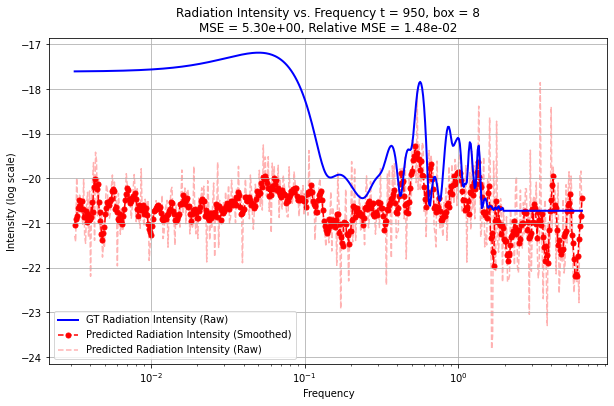

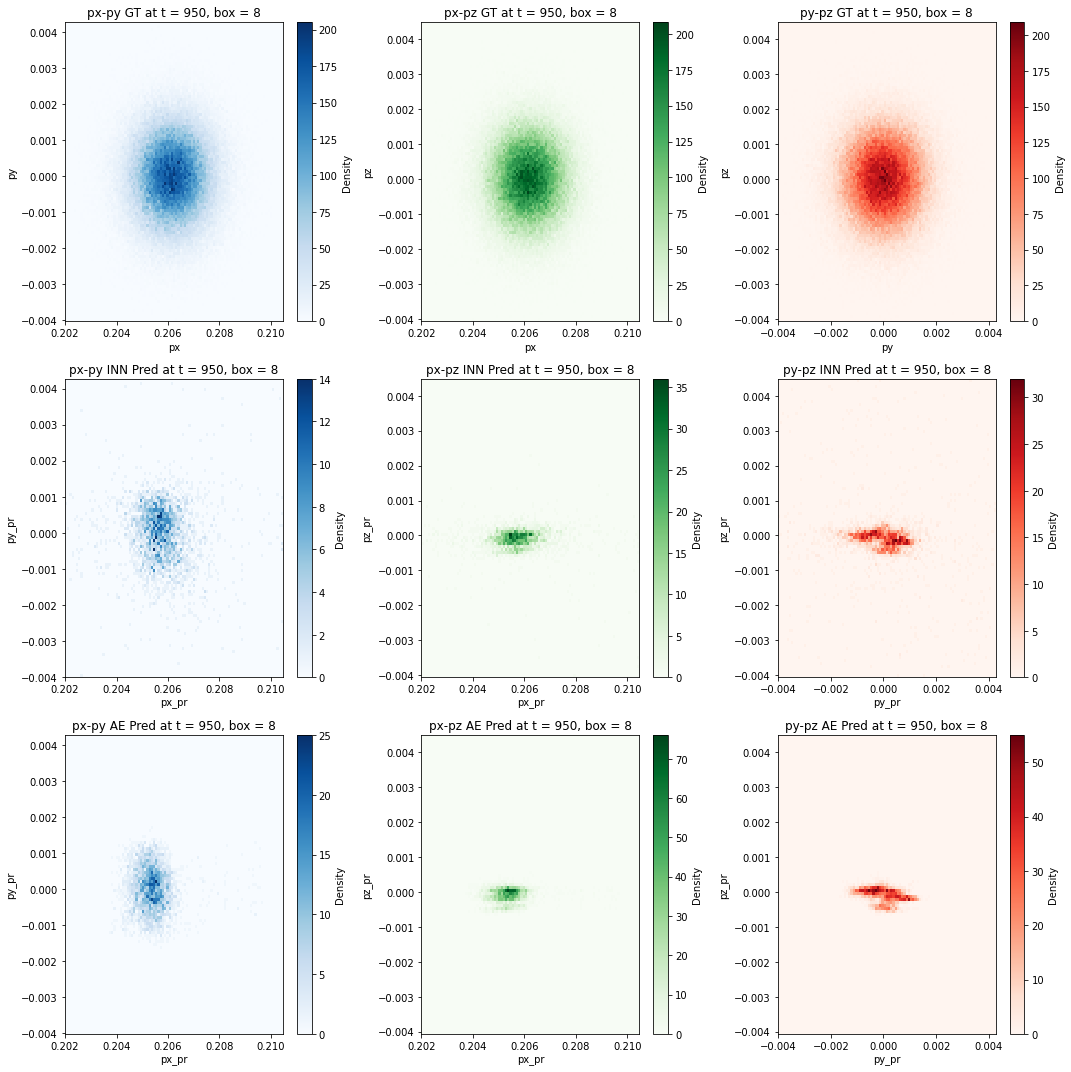

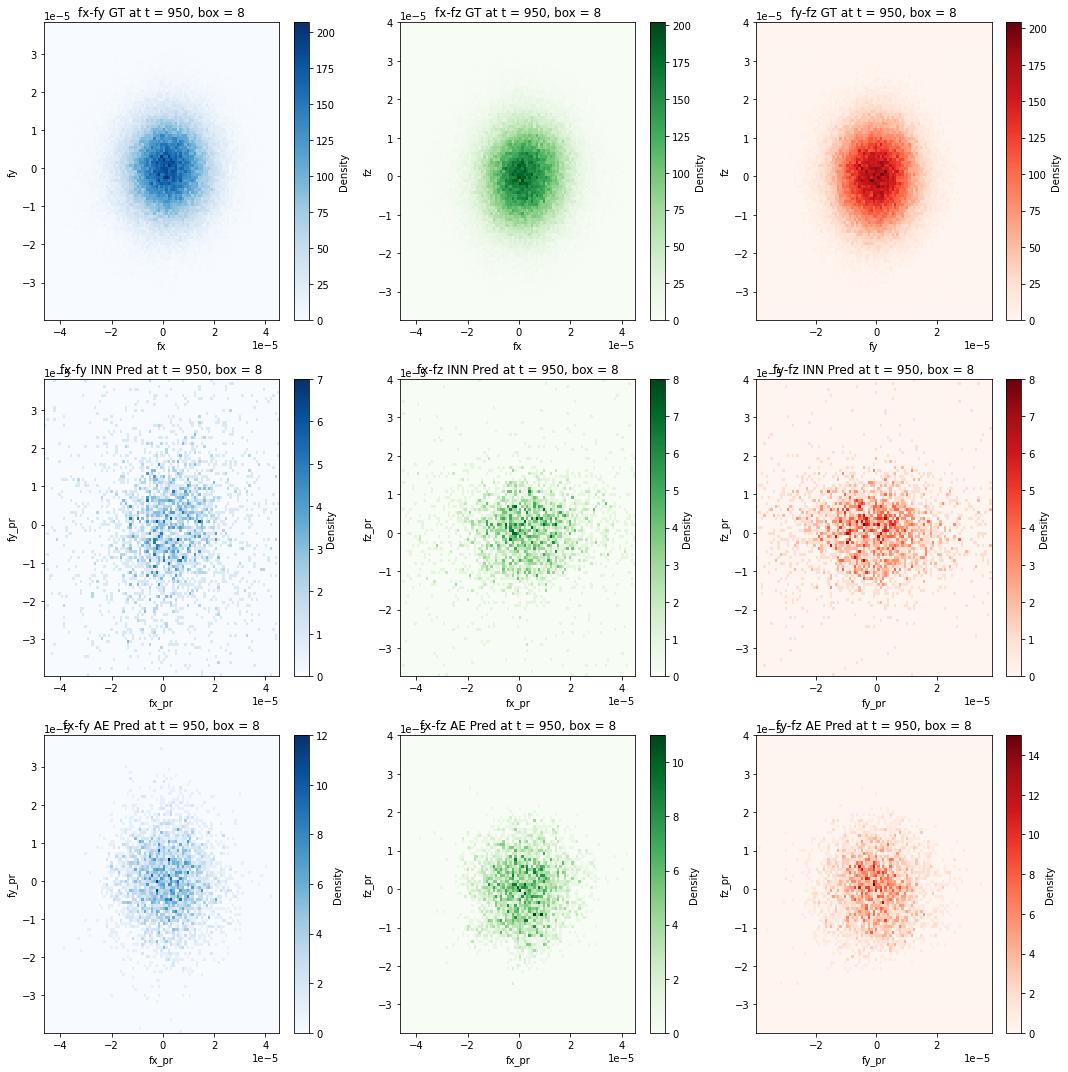

9


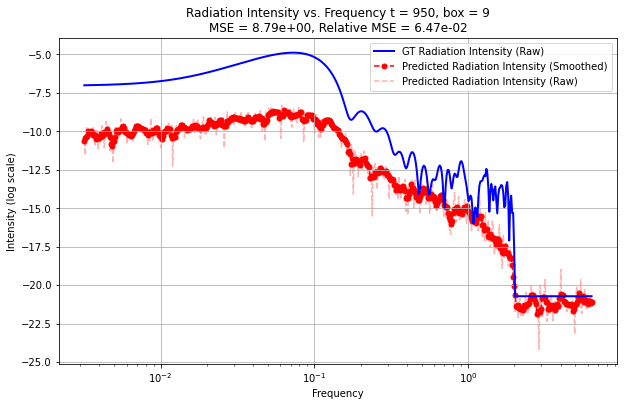

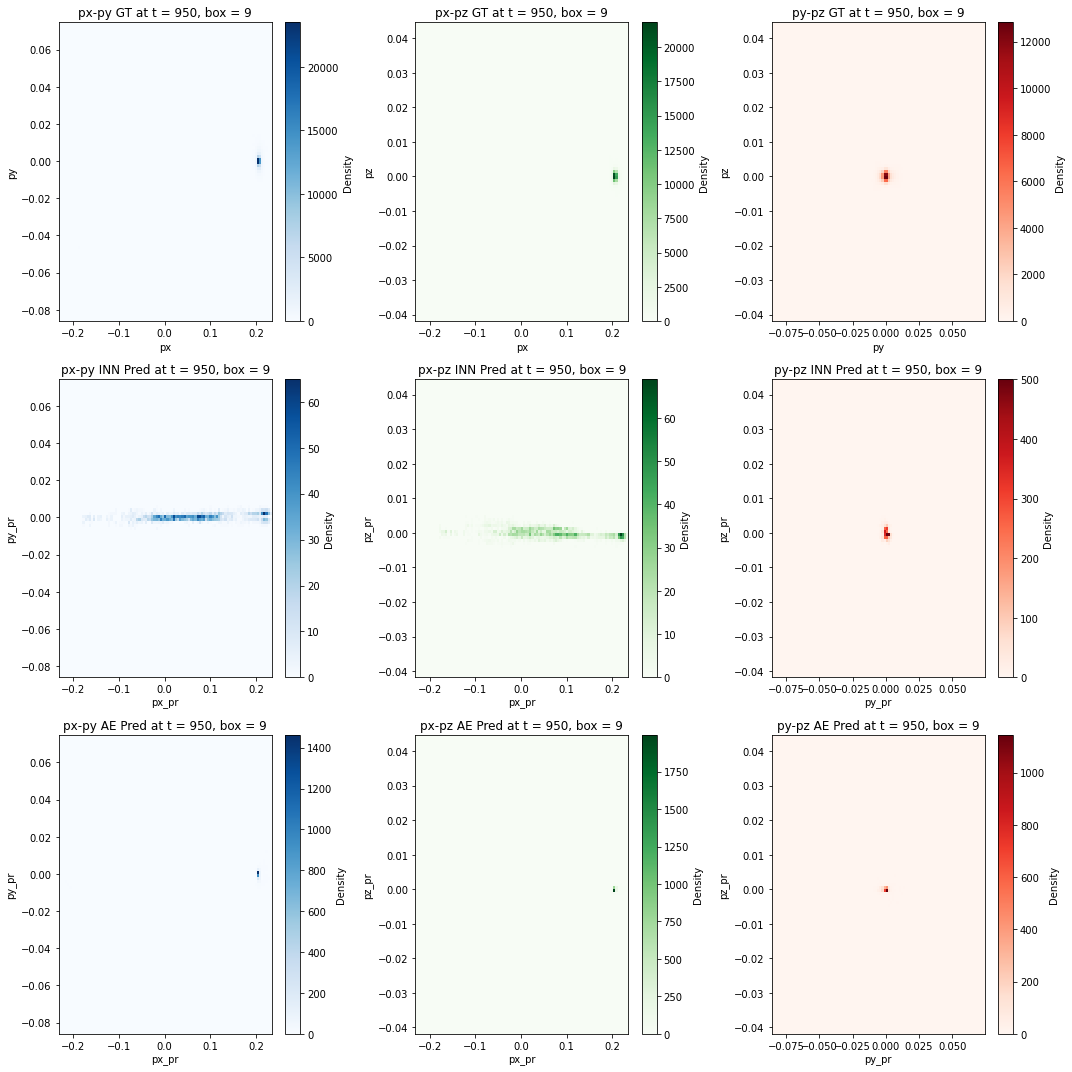

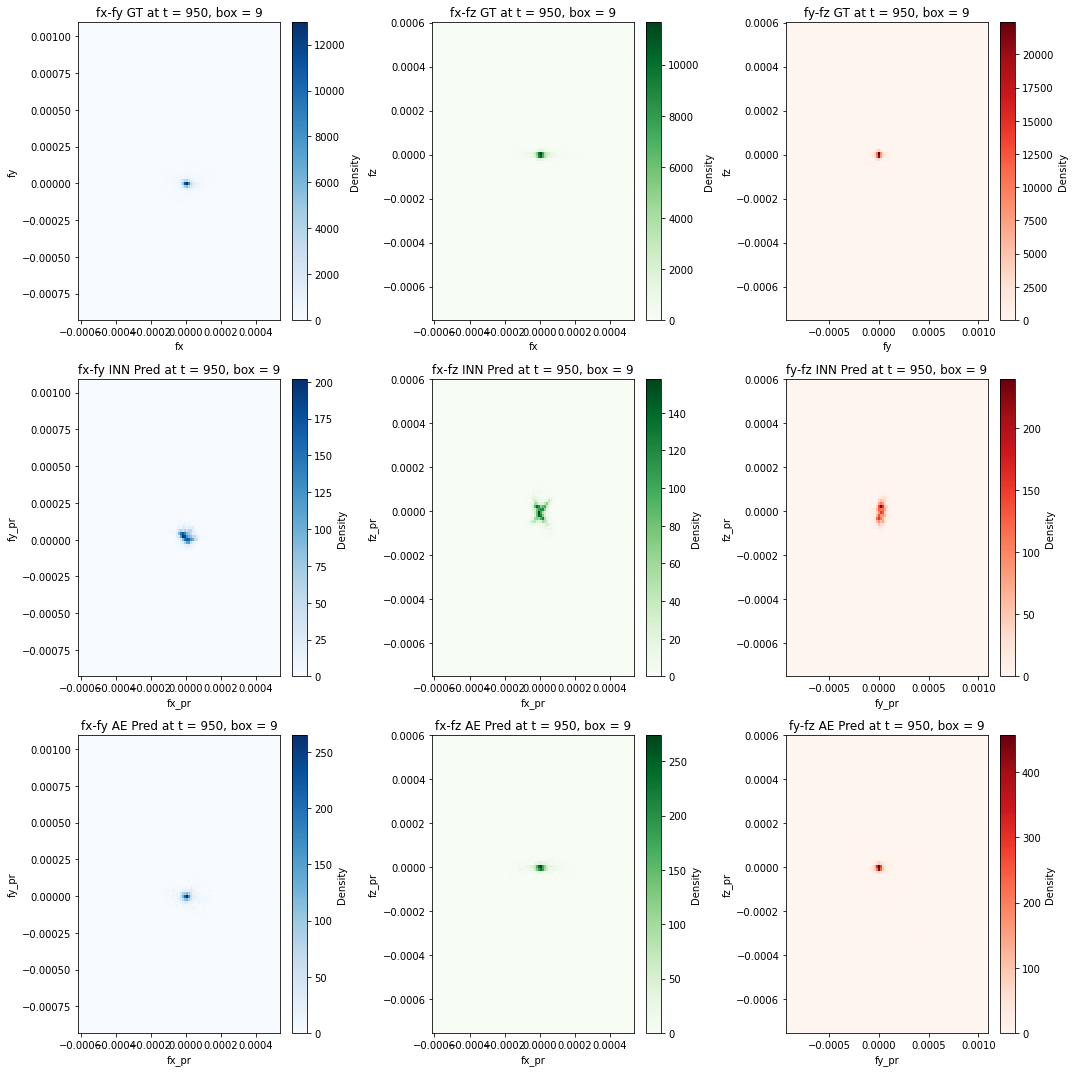

10


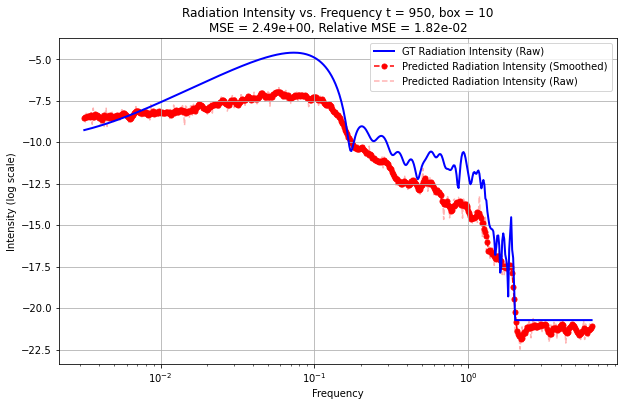

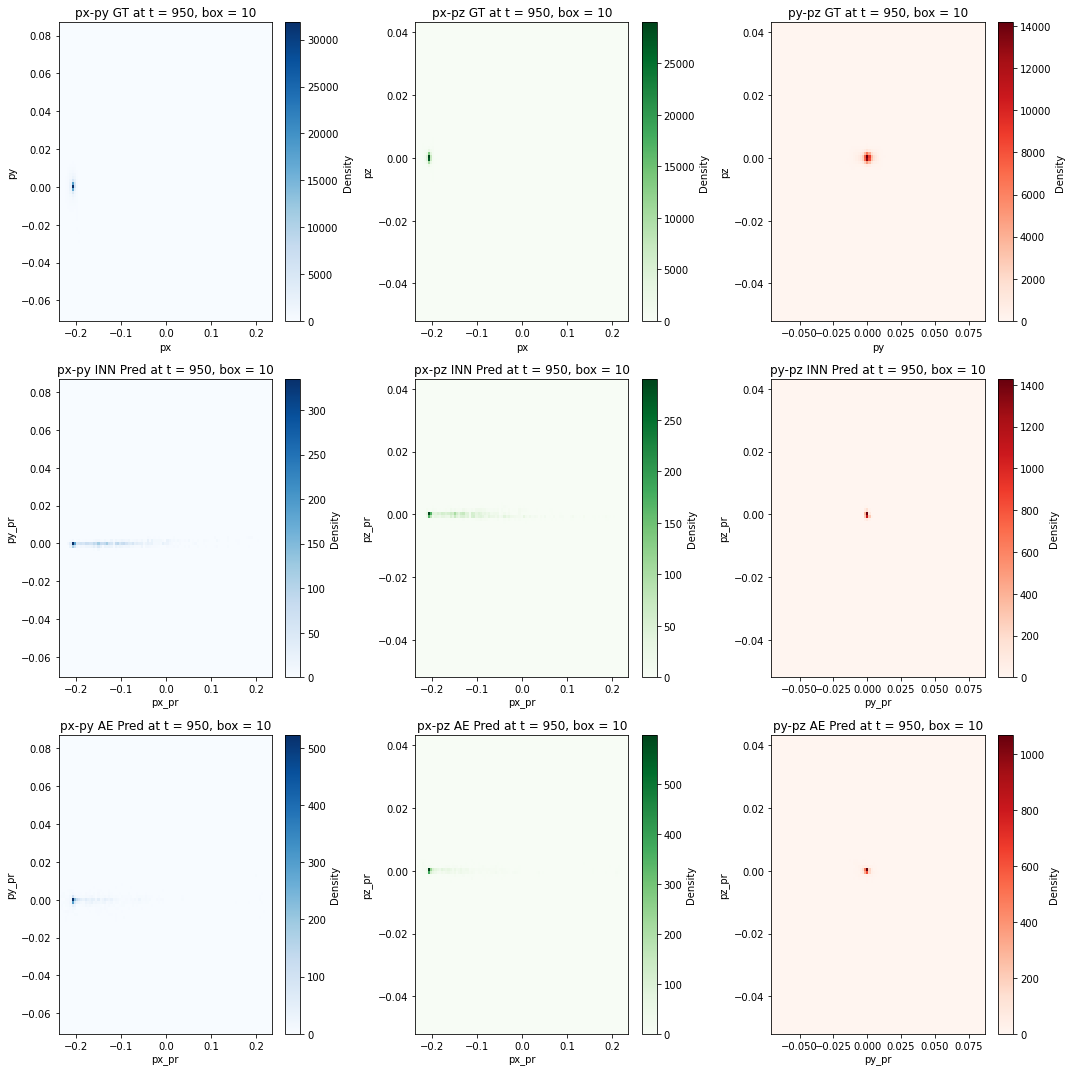

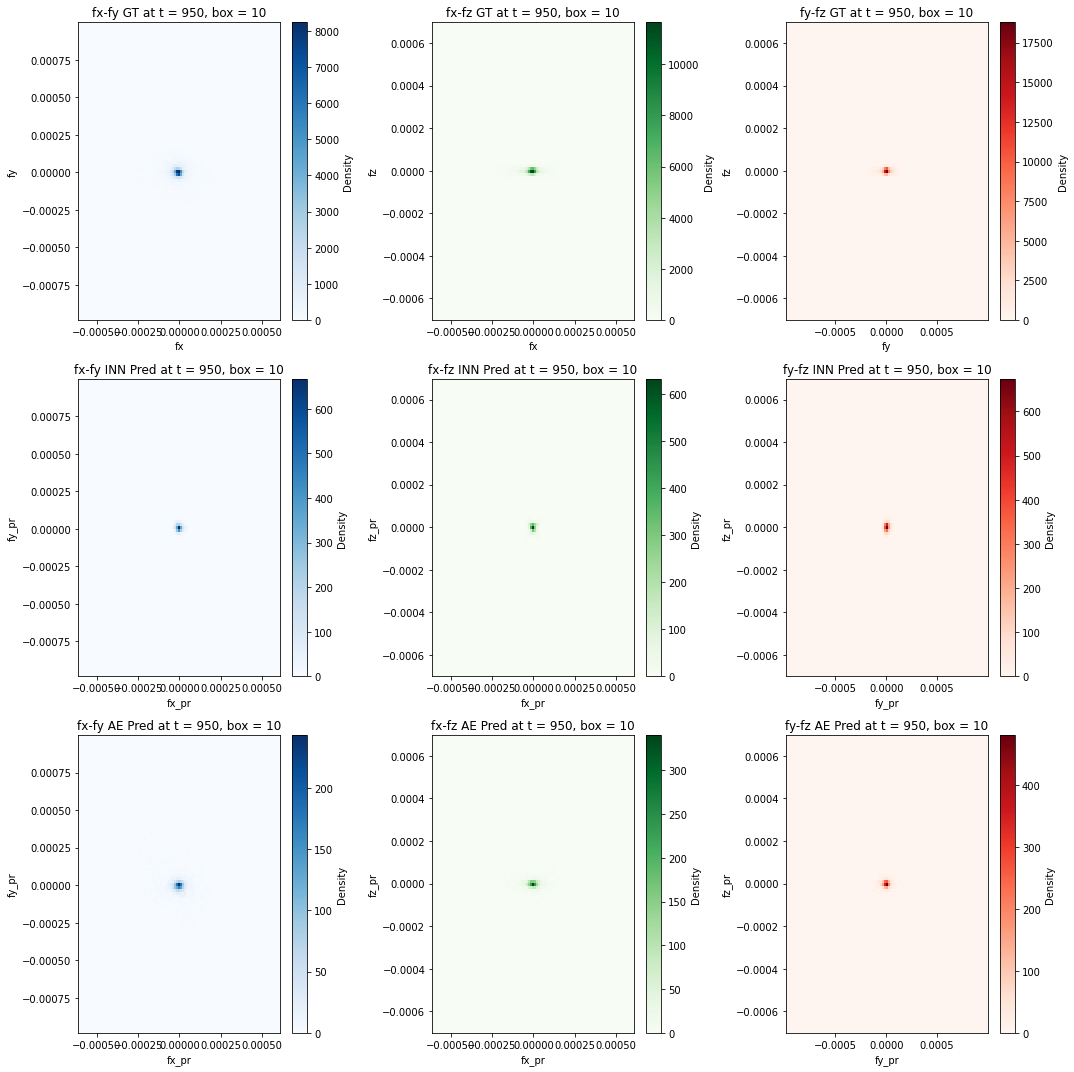

11


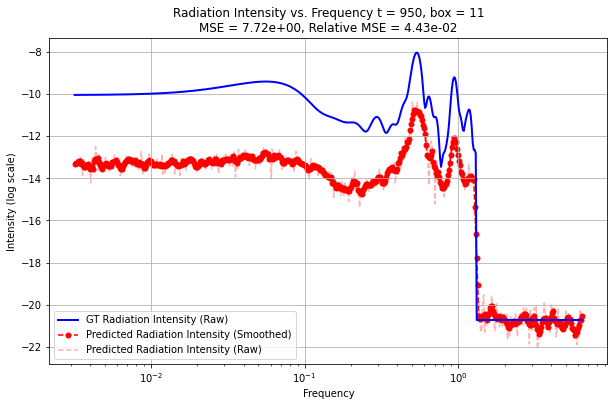

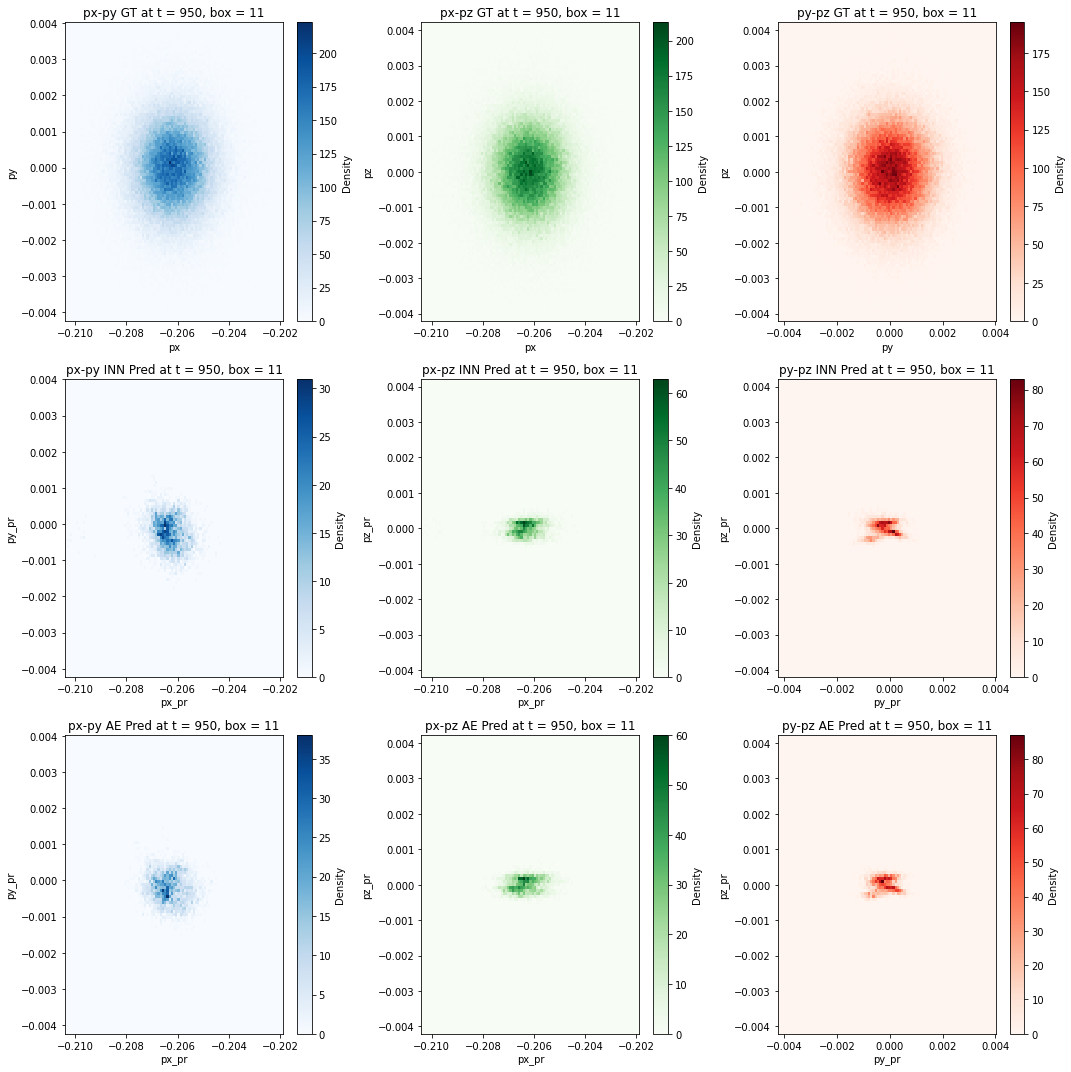

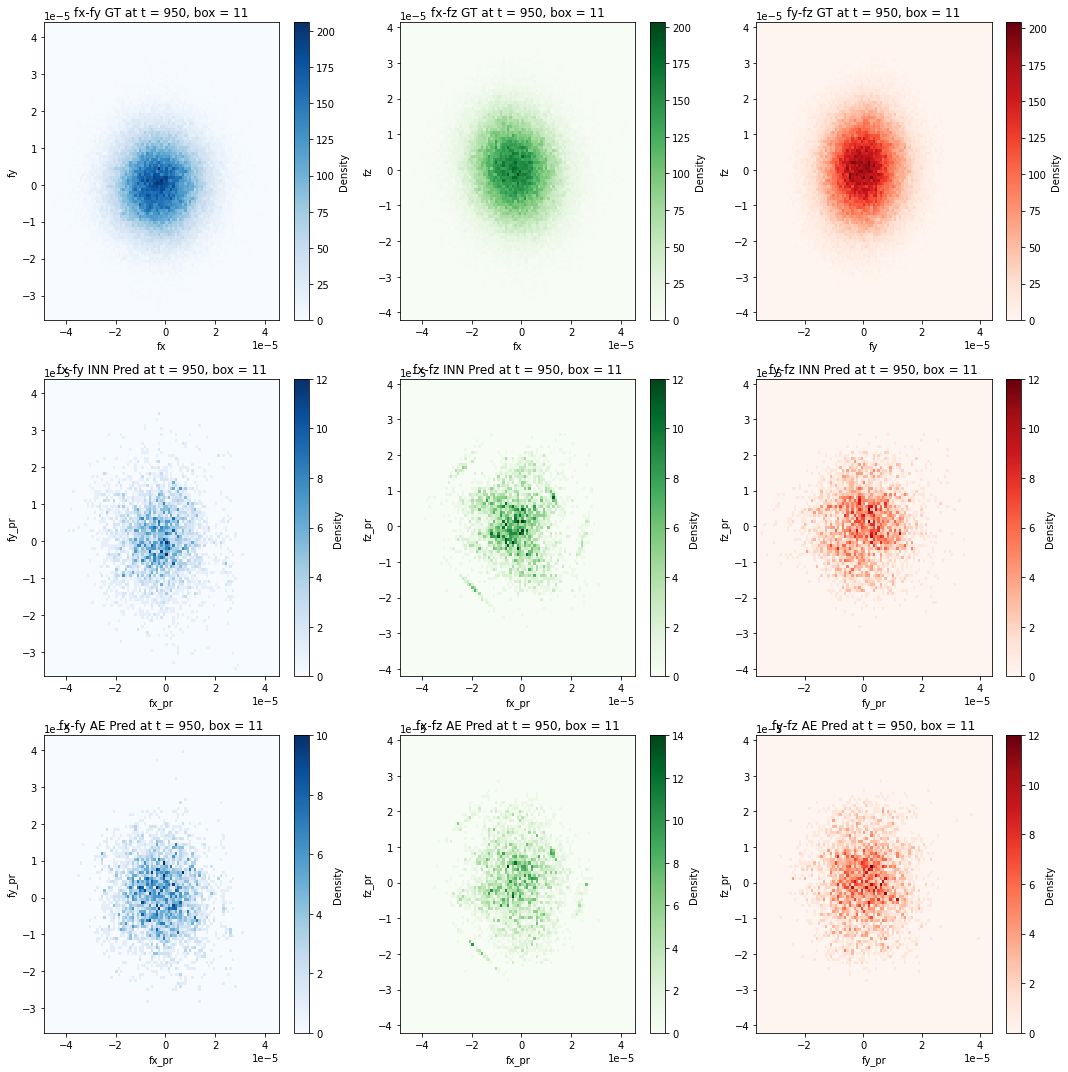

13


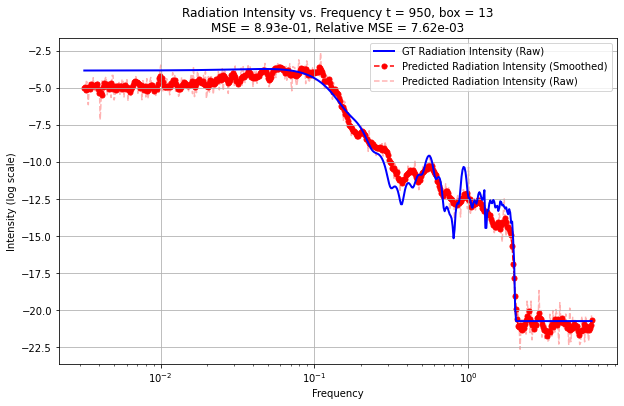

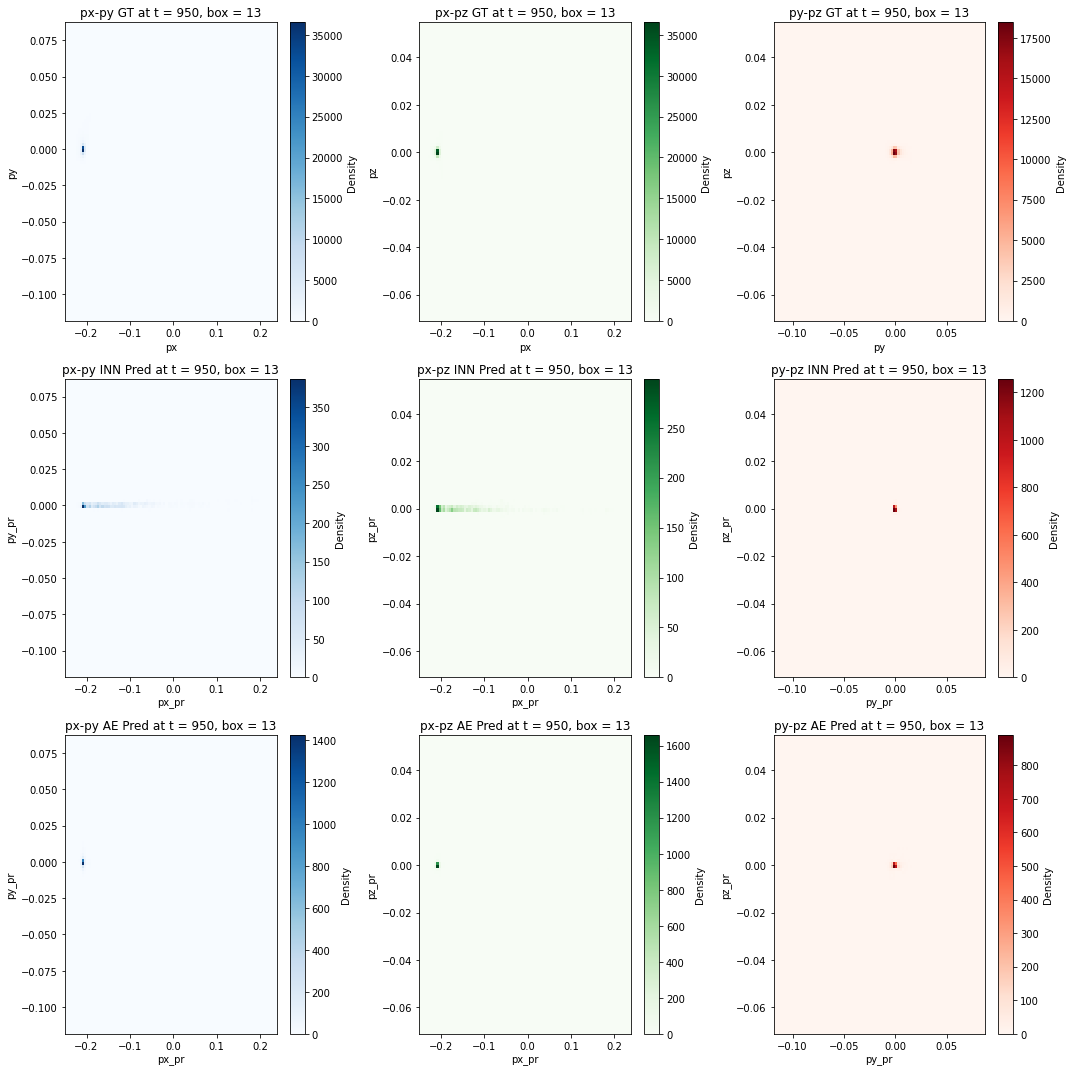

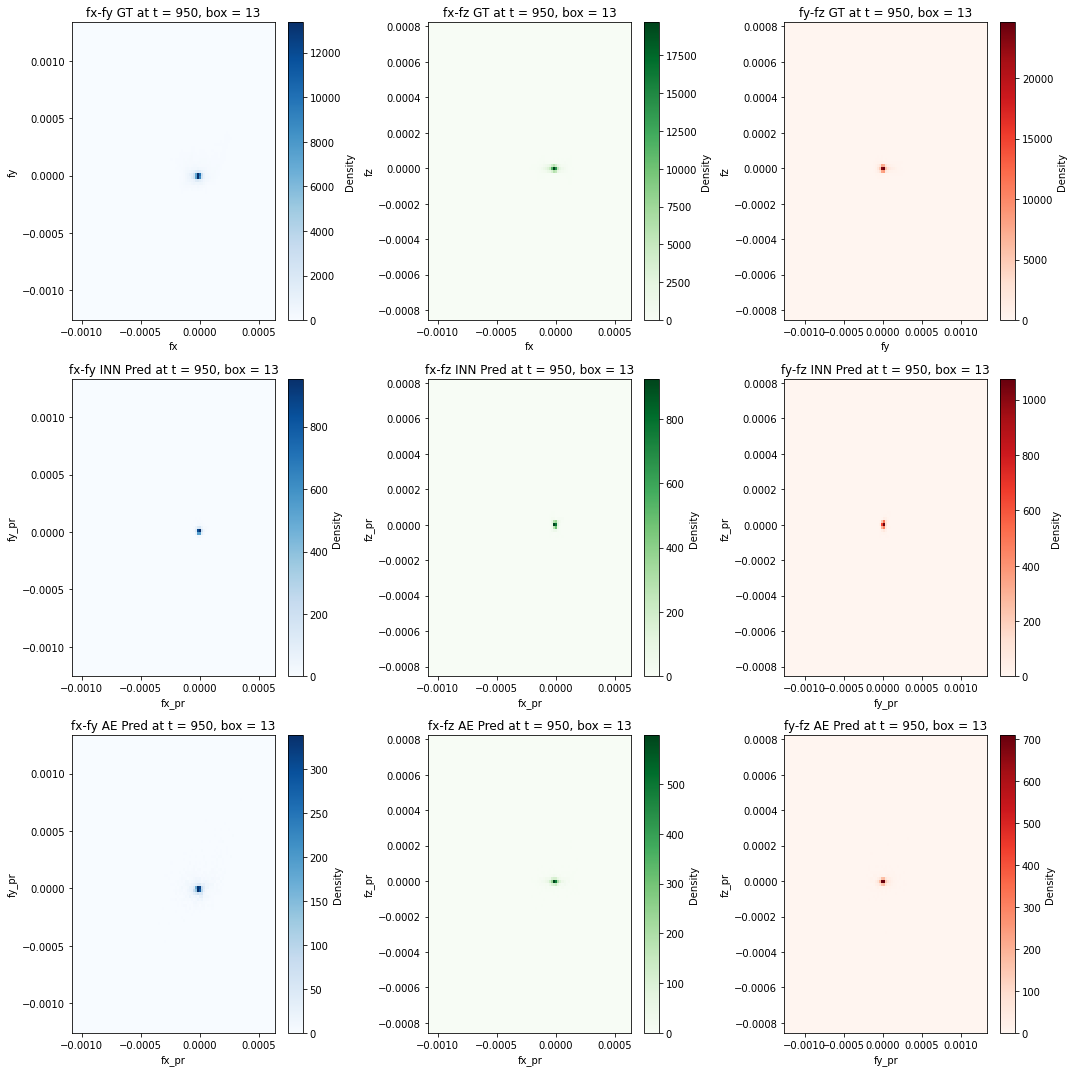

14


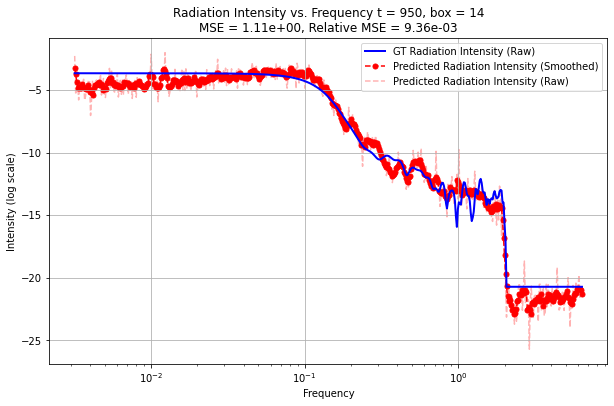

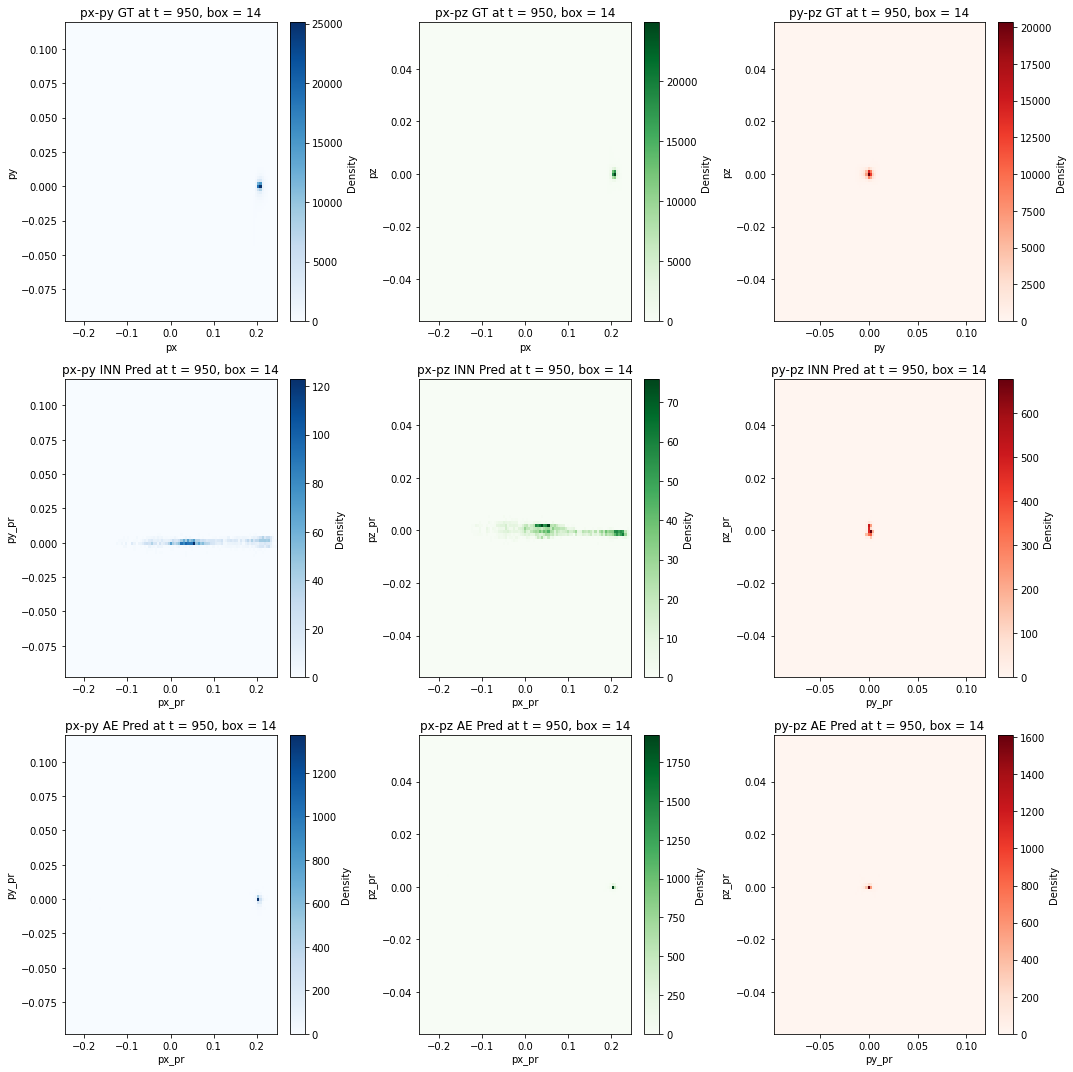

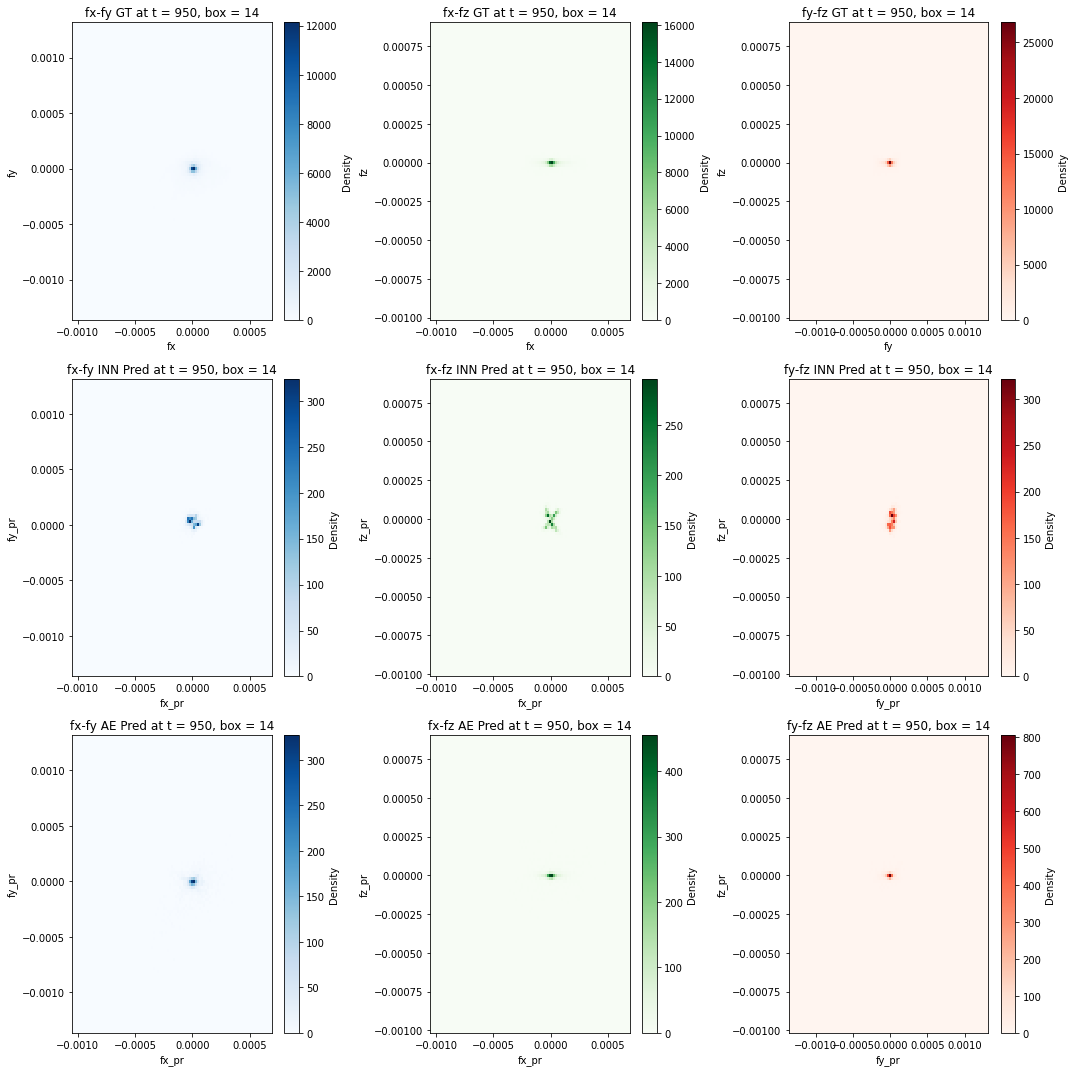

In [10]:
t_index = 950

# +x stream data --> 8
# -x stream data --> 11
# vortex with mainly +x stream --> 9,14
# vortex with mainly -x stream --> 10,13

gpu_indexes = [8, 9, 10, 11, 13, 14]

for gpu in gpu_indexes:
    print(gpu)
    r, rad_pred, p_gt, pc_pr, pc_pr_ae = generate_plots(model,t_index,gpu,pathpattern1,pathpattern2, config, device, enable_wandb = False)
    
    # filename = f"data_gpu_{gpu}_tindex_{t_index}.npz"
    # directory = "/bigdata/hplsim/aipp/Jeyhun/khi/part_rad/metrics/002_900_1001_yci9wlgu/" + filename
    # # Save the data to an .npz file
    # np.savez(directory, rad_gt=r, rad_pred=rad_pred.cpu(), ps_gt=p_gt, ps_pr_inn=pc_pr, ps_pr_ae=pc_pr_ae)